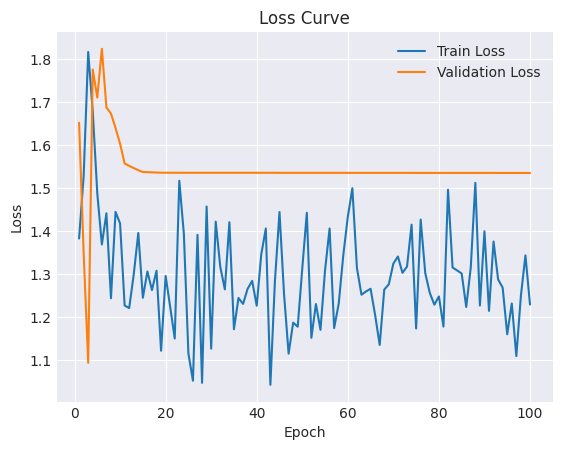

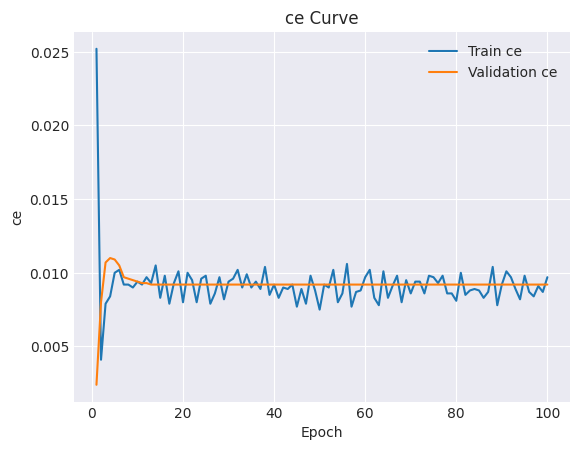

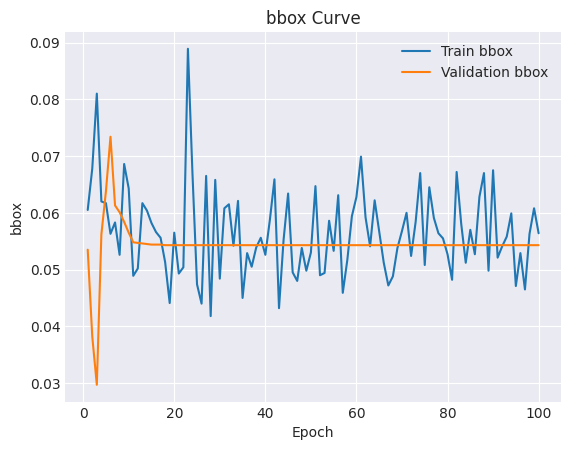

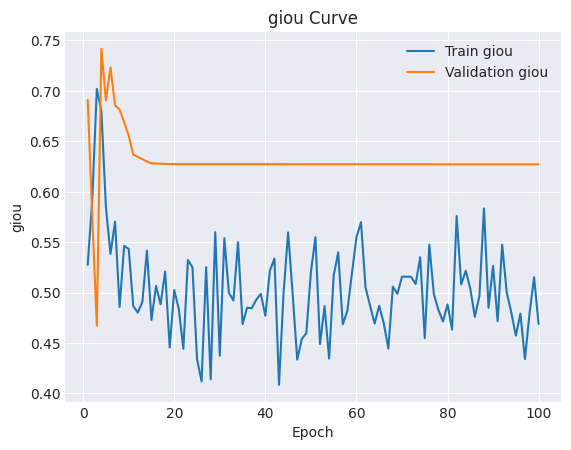

In [10]:
import re
import matplotlib.pyplot as plt

# 로그 파일 경로
log_file = "./ckpt_final/20250317_192558/train.log"  # 로그 파일 이름에 맞게 수정하세요

# 결과를 저장할 리스트 초기화
epochs = []

train_loss, val_loss = [], []
train_ce, val_ce = [], []
train_bbox, val_bbox = [], []
train_giou, val_giou = [], []

# 임시로 Validation 값들을 저장할 리스트 (로그 파일에서는 에포크별로 Validation 정보가 먼저 나오고, 이후에 Train 정보가 나온다고 가정)
val_loss_list = []
val_other_list = []  # (ce, bbox, giou)

# 로그 파일을 한 줄씩 읽으면서 정규표현식으로 값 추출
with open(log_file, "r", encoding="utf-8") as f:
    for line in f:
        # Validation Loss 추출
        if "Validation - Loss:" in line:
            m = re.search(r"Validation - Loss: ([\d\.]+)", line)
            if m:
                val_loss_list.append(float(m.group(1)))
        # Validation ce, bbox, giou 추출
        elif "Validation - ce:" in line:
            m = re.search(r"Validation - ce: ([\d\.]+), bbox: ([\d\.]+), giou: ([\d\.]+)", line)
            if m:
                ce_val = float(m.group(1))
                bbox_val = float(m.group(2))
                giou_val = float(m.group(3))
                val_other_list.append((ce_val, bbox_val, giou_val))
        # Train Loss와 함께 에포크 번호, Validation Loss(로그에 기록된 값) 추출
        elif "Epoch" in line and "Train Loss:" in line:
            m = re.search(r"Epoch (\d+)/\d+ - Train Loss: ([\d\.]+), Val Loss: ([\d\.]+)", line)
            if m:
                epoch = int(m.group(1))
                epochs.append(epoch)
                train_loss.append(float(m.group(2)))
                # 로그에 기록된 Validation Loss와 별도로 앞서 추출한 Validation Loss 값을 사용 (두 값이 동일할 것으로 가정)
                if val_loss_list:
                    val_loss.append(val_loss_list.pop(0))
                else:
                    val_loss.append(float(m.group(3)))
        # Train ce, bbox, giou 추출 (Train에 해당하는 값은 "Epoch X/100 - ce: ..." 형식)
        elif "Epoch" in line and "ce:" in line and "Train Loss:" not in line:
            m = re.search(r"Epoch \d+/100 - ce: ([\d\.]+), bbox: ([\d\.]+), giou: ([\d\.]+)", line)
            if m:
                train_ce.append(float(m.group(1)))
                train_bbox.append(float(m.group(2)))
                train_giou.append(float(m.group(3)))
                # 앞서 저장한 Validation ce, bbox, giou 값을 사용
                if val_other_list:
                    ce_val, bbox_val, giou_val = val_other_list.pop(0)
                    val_ce.append(ce_val)
                    val_bbox.append(bbox_val)
                    val_giou.append(giou_val)
                else:
                    val_ce.append(0)
                    val_bbox.append(0)
                    val_giou.append(0)

# 각 지표별로 그래프 그리기
def plot_metric(epochs, train_vals, val_vals, metric_name):
    plt.figure()
    plt.plot(epochs, train_vals, label=f"Train {metric_name}")
    plt.plot(epochs, val_vals, label=f"Validation {metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(epochs, train_loss, val_loss, "Loss")
plot_metric(epochs, train_ce, val_ce, "ce")
plot_metric(epochs, train_bbox, val_bbox, "bbox")
plot_metric(epochs, train_giou, val_giou, "giou")
